## Latent Space and Song Orders
We can now look at the trained samples in latent space. The latent space is a 2 dimensional representation of the wavesets ordered by similiarity. Each waveset is a point in the 2D space. We can think of a song as a series of jumps from waveset to waveset, i.e. a series of 2D coordinates. We want to save these series and train another network to create a new series.

In [1]:
from Variational_Autoencoder_alla_Valerio import VAE as Autoencoder
from Snippets import Snippets
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import librosa.feature.inverse
from IPython.display import display, Audio
import os

First we load the trained autoencoder and the training data from our disk:

In [2]:
subfolder = "4.0_256"
model_name = "VAE_Vocals_128D_4830samples_20Epochs"
path = os.path.join("data_and_models", subfolder, model_name)
autoencoder = Autoencoder.load(path)
#autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "Valerio"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 256, 1)]     0         
_________________________________________________________________
encoder (Functional)         (None, 128)               2100832   
_________________________________________________________________
decoder (Functional)         (None, 128, 256, 1)       665185    
Total params: 2,766,017
Trainable params: 2,763,073
Non-trainable params: 2,944
_________________________________________________________________
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 256, 1) 0                                  

In [3]:
num = 500
def load_data(subfolder):
    # Load the Snippet-Spectograms
    specto_path = os.path.join("data_and_models", subfolder, "spectos" + str(num) + ".npy")
    spectogram_data = np.load(specto_path)
    spectogram_data = spectogram_data[:autoencoder.num_of_train_data] # Model could have used only a part of the data during training
    
    # Load the Song_Labels (Note that we didn't use them during training)
    labels_path = speto_path = os.path.join("data_and_models", subfolder, "song_labels" + str(num) + ".npy")
    song_labels = np.load(labels_path)
    song_labels = song_labels[:autoencoder.num_of_train_data]
    
    # Load the Position_Labels (Note that we didn't use them during training)
    pos_label_path = os.path.join("data_and_models", subfolder, "position_labels" + str(num) + ".npy")
    position_labels = np.load(pos_label_path)
    position_labels = position_labels[:autoencoder.num_of_train_data]

    print("Shape of the loaded data: " + str(spectogram_data.shape))
    
    return spectogram_data, position_labels, song_labels

x_train, y_train, y_train_alt = load_data(subfolder)

(4830, 128, 256, 1)


## Data in latent space
We can now plot our wavesets in the latent space. Each waveset is reduced to a point in the 2 dimensional space. The distance between the points of two wavesets corresponds to their similarity. The colors represent at which position in a song the waveset occured (first 10% of the song, second 10% of the song and so on).

In [4]:
latent_representation = autoencoder.encoder.predict(x_train)

C:\Users\FynnFrei\Documents\GitHub\MetaHuman\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


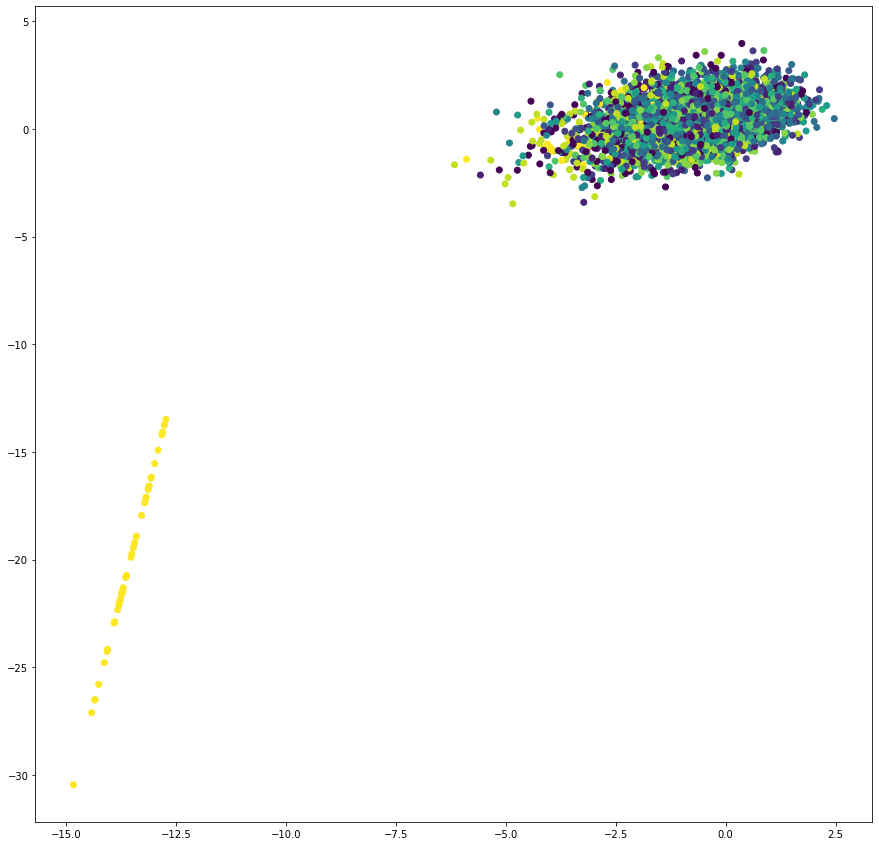

In [5]:
plt.figure(figsize=(15, 15))
plt.scatter(latent_representation[:, 0], latent_representation[:, 1], c=y_train)
plt.colorbar
plt.show()

## Generate Song Orders
A song is a series of wavesets. This series of wavesets corresponds to a list of coordinates in the latent space. It can be imagined as a movement - or more precisely a sequence of jumps - through the latent space. Later we want to use these sequences as training data for a second network. On their basis the second network will be able to produce new sequences. For this we need to store the series of coordinates for each song. We create a list of 2D arrays: first dimension is the song, and second dimension is the a tuple of coordinates.

In [6]:
path = os.path.join("data_and_models", subfolder, "SnippetNum" + str(num) + ".npy")
num_of_snippets_per_song = np.load(path)

# If only a part of the data was used during training, we have to cut the array
ws_sums = np.cumsum(num_of_snippets_per_song)
num_of_snippets_per_song = num_of_snippets_per_song[:np.argwhere(ws_sums > x_train.shape[0]).min()]

start_ws = 0
stop_ws = 0
song_orders = []

for i, num_of_snippet in enumerate(num_of_snippets_per_song):
    stop_ws += num_of_snippet
    song_order = latent_representation[start_ws : stop_ws]
    song_order = np.reshape(song_order, (num_of_snippet, autoencoder.latent_space_dim))
    song_orders.append(song_order)
    start_ws += num_of_snippet
    
song_orders = np.asarray(song_orders, dtype=object)

(90,)

We save the new list of song_orders on disk for later use:

In [7]:
save_path = os.path.join("data_and_models", subfolder, model_name + "_song_order" + str(num) + ".npy")
np.save(save_path,song_orders)

## The latent space representation of one song
We can plot the latent representation of a song. The subsequent wavesets are connected by lines to visualize, that the sequence of wavesets corresponds to a path trough the latent space.

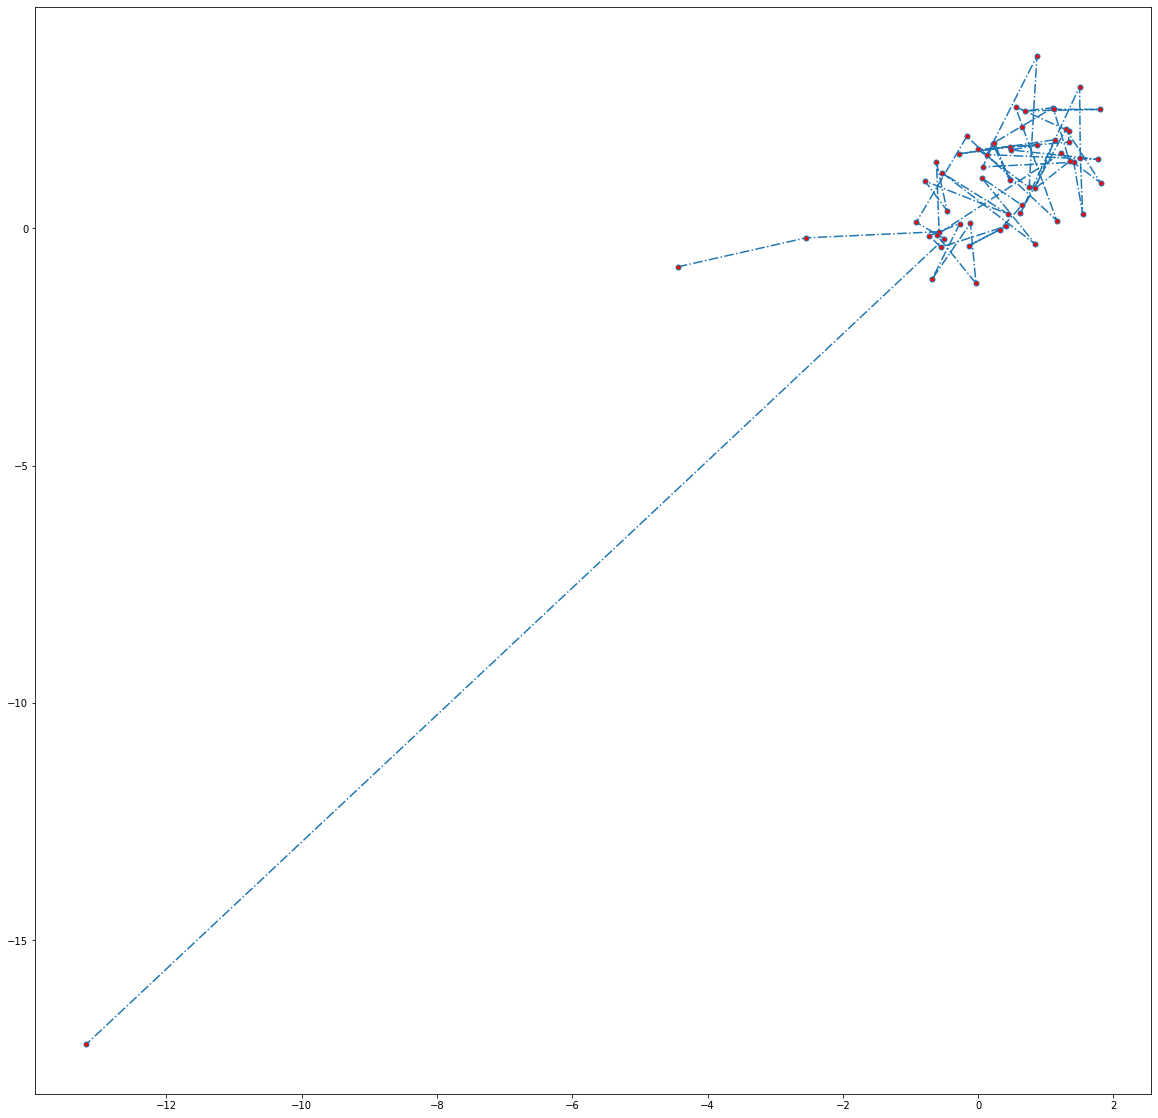

In [12]:
song_num = np.random.randint(0, num_of_snippets_per_song.shape[0])
plt.figure(figsize=(20,20))
plt.plot(song_orders[song_num][:, 0], song_orders[song_num][:, 1], '-.o', markersize=5, markerfacecolor='red')
plt.show()

## Create a new Waveset
We can try the conversion, by letting the autoencoder reconstruct a junk of audio. We feed the spectograms of some audio-snippets to the encoder to get their latent representation. We can then test how much information gets lost in the autoencoder by passing the latent_representation to our decoder, which will spit out a reconstructed spectogram, which we can then use to reconstruct pcm-data. 

In [13]:
WIN_LENGTH = 690*2
HOP_LENGTH = 690
N_FFT = 690*2

index = np.random.randint(0, x_train.shape[0]) # Choose a random snippet as the start

In [14]:
original_signal, original_spectos = Snippets.reconstructed_spectos_to_pcm(x_train[index:index+10], hop_length=HOP_LENGTH, n_fft=N_FFT, win_length=WIN_LENGTH)
Snippets.plot_specto(original_spectos, "Original Specto", HOP_LENGTH)
print("\n This is the original Audio:")
display(Audio(original_signal,rate=44100))


KeyboardInterrupt



In [ ]:
recon_signal, recon_specto = Snippets.specto_to_pcm(data=x_train[index:index+10], 
                                                    model=autoencoder, 
                                                    hop_length=HOP_LENGTH, 
                                                    n_fft=N_FFT, 
                                                    win_length=WIN_LENGTH)
Snippets.plot_specto(recon_specto, "Reconstructed Specto", HOP_LENGTH)
print("\n This is the reconstructed Audio:")
display(Audio(recon_signal,rate=44100))

We can also try what happens, if we use random points in the latent space and use them as coordinates for our song. We sample a random point, reconstruct the corresponding spectogram and use it to reconstruct pcm-data.

In [ ]:
random_points = np.random.rand(40, latent_representation.shape[1])
random_points = (random_points * 5) - 2.5 # We center the random points around the origin
random_points

In [ ]:
random_signal, random_spectos = Snippets.latent_representation_to_pcm(latent_representations=random_points,
                                                                      model=autoencoder,
                                                                      hop_length=HOP_LENGTH, 
                                                                      n_fft=N_FFT, 
                                                                      win_length=WIN_LENGTH)
Snippets.plot_specto(random_spectos, "Random Specto", HOP_LENGTH)
print("\n This is the reconstruction of random points in the latent space:")
display(Audio(random_signal,rate=44100))